In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mkdir './data'
!unzip '/content/drive/My Drive/Steering_Datasets_Rev1/Simulator_Dataset/IMG6.zip' -d '/content/data'

In [0]:
import pandas as pd 

drive_log = pd.read_csv('/content/data/IMG6/driving_log.csv') 
data = drive_log.iloc[:,:4]
data.columns = [ 'center', 'left', 'right', 'angle']

# print(data.iloc[0,0])

# could probably do this better 
def get_file_names(data):
  for i, name in enumerate(data['left']): 
    a = name.split('\\')
    data.loc[i,'left'] = a[-1]

  for i, name in enumerate(data['right']): 
    a = name.split('\\')
    data.loc[i,'right'] = a[-1]

  for i, name in enumerate(data['center']): 
    a = name.split('\\')
    data.loc[i,'center'] = a[-1]

  return data 

data = get_file_names(data)

data.head()

,center,left,right,angle
0,center_2020_04_27_16_36_10_334.jpg,left_2020_04_27_16_36_10_334.jpg,right_2020_04_27_16_36_10_334.jpg,0.0
1,center_2020_04_27_16_36_10_417.jpg,left_2020_04_27_16_36_10_417.jpg,right_2020_04_27_16_36_10_417.jpg,0.0
2,center_2020_04_27_16_36_10_505.jpg,left_2020_04_27_16_36_10_505.jpg,right_2020_04_27_16_36_10_505.jpg,0.0
3,center_2020_04_27_16_36_10_604.jpg,left_2020_04_27_16_36_10_604.jpg,right_2020_04_27_16_36_10_604.jpg,0.0
4,center_2020_04_27_16_36_10_674.jpg,left_2020_04_27_16_36_10_674.jpg,right_2020_04_27_16_36_10_674.jpg,0.0


In [0]:
# renamed columns to properly concat together, maybe a better way?  
center_data = data[['center', 'angle']].copy(); center_data.columns = ['img', 'angle']
left_data = data[['left', 'angle']].copy(); left_data.columns = ['img', 'angle']
right_data = data[['right', 'angle']].copy(); right_data.columns = ['img', 'angle']

frames = [center_data, left_data, right_data]
new_data = pd.concat(frames, ignore_index=True)
new_data

,img,angle
0,center_2020_04_27_16_36_10_334.jpg,0.000000
1,center_2020_04_27_16_36_10_417.jpg,0.000000
2,center_2020_04_27_16_36_10_505.jpg,0.000000
3,center_2020_04_27_16_36_10_604.jpg,0.000000
4,center_2020_04_27_16_36_10_674.jpg,0.000000
...,...,...
125356,right_2020_04_27_18_57_07_664.jpg,0.585294
125357,right_2020_04_27_18_57_07_750.jpg,0.335294
125358,right_2020_04_27_18_57_07_825.jpg,0.000000
125359,right_2020_04_27_18_57_07_906.jpg,0.000000


## Not splitting data into train/validation 

Steering Angle:  0.9764706 -0.1647059


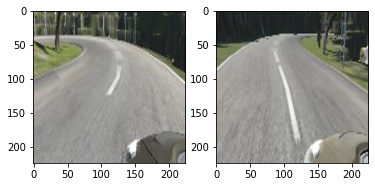

In [0]:
import torch 
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import torchvision 

import os 
import glob 
from PIL import Image 



# left and right images
class SteeringDataset(Dataset): 
  def __init__(self, img_path, data, data_transforms=None): 
    self.data = data # a Pandas dataframe from cell above 
    self.data_transforms = data_transforms 
    self.img_path = img_path 

  def __len__(self): 
    return len(self.data) 

  def __getitem__(self, idx):
    
    img = Image.open(self.img_path + self.data.loc[idx,'img'])
    angle = self.data.loc[idx, 'angle']

    img = img.crop((0,50, 320, 160))
    img = img.resize((224,224))
    if self.data_transforms: 
      img = self.data_transforms(img)
    
    sample = (img, angle)
    return sample 


import matplotlib.pyplot as plt 
ds = SteeringDataset('/content/data/IMG6/', new_data, torchvision.transforms.ToTensor()) 

# Show image 
left, angle1 = ds[np.random.randint(len(ds),size=1)[0]]
right, angle2 = ds[np.random.randint(len(ds)/2,size=1)[0]]
to_pil = torchvision.transforms.ToPILImage()      
left = to_pil(left)
right = to_pil(right)
f, axes = plt.subplots(1,2)
axes[0].imshow(left)
axes[1].imshow(right)
print('Steering Angle: ', angle1, angle2)  

In [0]:
B = 16
train_loader = DataLoader(ds, batch_size = B, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn 
import torchvision.models as models 
# Define model 
model = models.resnet18(pretrained=False, progress=True).to(device)
for param in model.parameters():
    param.requires_grad = True 
model.fc = nn.Sequential(nn.Linear(512, 512),
                          nn.ReLU(),
                          nn.Linear(512, 1)).to(device)


class ClassificationLoss(torch.nn.Module):
    def forward(self, input, target):
        m = nn.MSELoss()
        return torch.sqrt(m(input.view(input.size(0)),target))
        
# Define loss and optimizer 
import torch.optim as optim 
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = ClassificationLoss()


In [0]:
def train(model, criterion, optimizer, num_epochs):
  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # device = 'cpu'
  model.train()
  model.to(device)
  batch_losses = []
  epoch_losses = []
  for e in range(num_epochs): 
    for i, (image, angle) in enumerate(train_loader): 
      input = image.to(device)
      targets = angle.to(device)
      
      
      optimizer.zero_grad() 
    
      output = model(input).to(device)
      loss = criterion(output, targets.type(torch.FloatTensor).to(device))
      batch_losses.append(loss)
      loss.backward() 
      optimizer.step() 

      if i % 100 == 0: 
        mean_loss = sum(batch_losses)/len(batch_losses)
        epoch_losses.append(mean_loss)
        print(f'Epoch:{e}  Batch:{i}  Avg.Loss = {mean_loss}')
        del batch_losses[:]
    print(f'\n Average loss for Epoch {e} is {sum(epoch_losses)/len(epoch_losses)}\n')
    del epoch_losses[:]

  torch.save(model.state_dict(), 'resnet_clr_train.pt')


train(model, criterion, optimizer, num_epochs=6)

Epoch:0  Batch:0  Avg.Loss = 0.40154024958610535
Epoch:0  Batch:100  Avg.Loss = 0.36595237255096436
Epoch:0  Batch:200  Avg.Loss = 0.29221051931381226
Epoch:0  Batch:300  Avg.Loss = 0.26340940594673157
Epoch:0  Batch:400  Avg.Loss = 0.2531571090221405
Epoch:0  Batch:500  Avg.Loss = 0.2529084384441376
Epoch:0  Batch:600  Avg.Loss = 0.2585922181606293
Epoch:0  Batch:700  Avg.Loss = 0.23163028061389923
Epoch:0  Batch:800  Avg.Loss = 0.2361559271812439
Epoch:0  Batch:900  Avg.Loss = 0.23509758710861206
Epoch:0  Batch:1000  Avg.Loss = 0.23461806774139404
Epoch:0  Batch:1100  Avg.Loss = 0.2336292415857315
Epoch:0  Batch:1200  Avg.Loss = 0.23166295886039734
Epoch:0  Batch:1300  Avg.Loss = 0.23283621668815613
Epoch:0  Batch:1400  Avg.Loss = 0.23206128180027008
Epoch:0  Batch:1500  Avg.Loss = 0.23673102259635925
Epoch:0  Batch:1600  Avg.Loss = 0.22976475954055786
Epoch:0  Batch:1700  Avg.Loss = 0.22902709245681763
Epoch:0  Batch:1800  Avg.Loss = 0.22861333191394806
Epoch:0  Batch:1900  Avg.Loss